<a href="https://colab.research.google.com/github/skughered/wet_finger_investing/blob/main/timing_luck_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tiingo
!pip install matplotlib
!pip install scipy

import pandas as pd
from tiingo import TiingoClient as tii
from datetime import datetime as dt
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import itertools
import matplotlib.ticker as mticker


In [2]:

# API code
def tiingo_data(metric_name='adjClose'):
    # Your Tinngo.com API Token
    api = '9c6d1991a2f70ee6e29f20df344feb9e1d90267d'

    # Configuration
    config = {'api_key': api, 'session': True}
    client = tii(config)

    # Instrument List
    instrument_list = ['IEF', 'SPY']

    # Fetching adjusted close prices since 31/07/2007
    start_date = '2002-08-01'
    # Dynamic end date (today's date)
    end_date = dt.now().strftime('%Y-%m-%d')

    # Get a DataFrame of adjusted close prices for the list of symbols
    ticker_history = client.get_dataframe(instrument_list,
                                          frequency='daily',
                                          metric_name='adjClose',
                                          startDate=start_date,
                                          endDate=end_date)

    ticker_history.index = pd.to_datetime(ticker_history.index)

    return ticker_history


# Using the function above create a price dataframe & also a daily percentage change dataframe
load_etf_prices = tiingo_data(metric_name='adjClose')
etf_pct_returns = load_etf_prices.pct_change()
monthly_etf_rtns = etf_pct_returns.resample('M').sum()

In [3]:
def calculate_portfolio_returns(df):
    # Define the rebalancing schedule
    rebalance_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
                        'October', 'November', 'December']

    # Initial weights
    initial_weights = {'SPY': 0.6, 'IEF': 0.4}

    # Initialize the portfolio values
    portfolio_returns = pd.DataFrame(index=df.index)

    # Initialize 12 portfolios
    portfolios = {month: initial_weights.copy() for month in rebalance_months}

    # Calculate portfolio returns for each month
    for date in df.index:
        month_name = date.month_name()
        for rebalance_month, weights in portfolios.items():
            # Check if it's time to rebalance this portfolio
            if month_name == rebalance_month:
                weights.update(initial_weights)

            # Calculate new asset values after market drift
            asset_values = {asset: weights[asset] * (1 + df.at[date, asset]) for asset in df.columns}

            # Total value of the portfolio after drift
            total_value = sum(asset_values.values())

            # Recalculate weights based on new asset values
            weights.update({asset: value / total_value for asset, value in asset_values.items()})

            # Calculate the portfolio return for the month
            portfolio_return = sum([df.at[date, asset] * weights[asset] for asset in df.columns])
            portfolio_returns.at[date, f'Portfolio_{rebalance_month}'] = portfolio_return

    return portfolio_returns


portfolio_returns = calculate_portfolio_returns(monthly_etf_rtns)

In [4]:
# Check for stationarity and model autocorrelation
ar_models = {}
for column in portfolio_returns.columns:
    model = AutoReg(portfolio_returns[column].dropna(), lags=1).fit()
    ar_models[column] = model.resid

# Pairwise t-tests
p_values = []
combinations = itertools.combinations(portfolio_returns.columns, 2)
for combo in combinations:
    stat, p = ttest_ind(ar_models[combo[0]], ar_models[combo[1]], equal_var=False)
    p_values.append(p)

# Bonferroni Correction
alpha = 0.05
p_adjusted = np.array(p_values) * len(p_values)
significant_pairs = [i for i, p in enumerate(p_adjusted) if p < alpha]

# Output results
if significant_pairs:
    print("Significant differences found in the following portfolio pairs:")
    for i in significant_pairs:
        print(list(combinations)[i])
else:
    print("No significant differences found.")

No significant differences found.


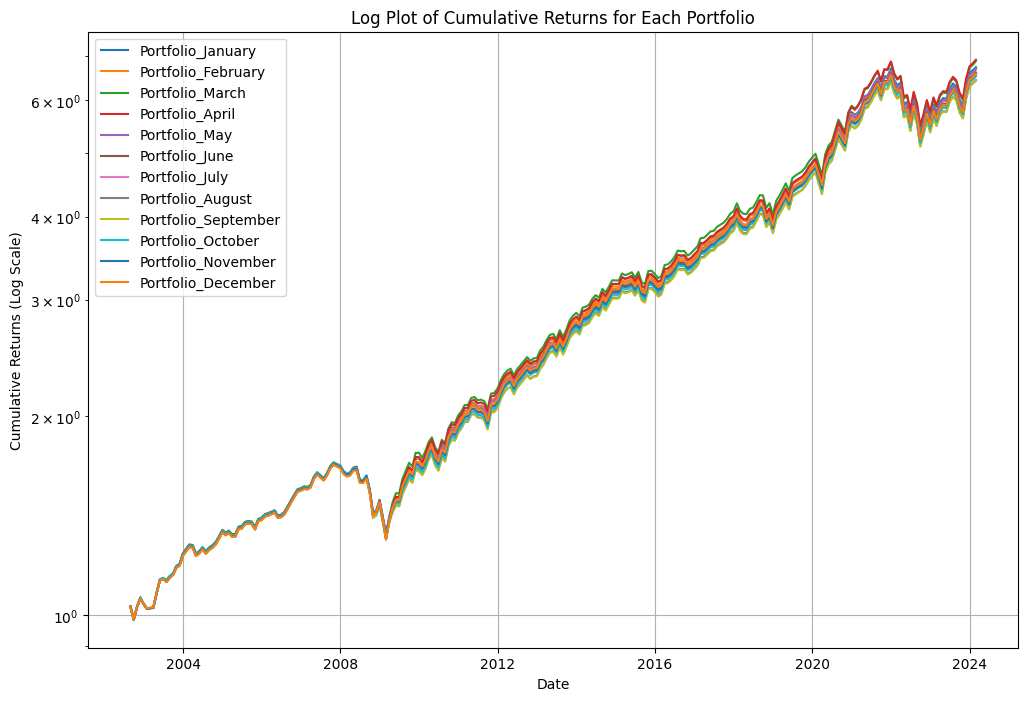

In [5]:
def plot_cumulative_returns(portfolio_returns):
    # Calculate cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()

    # Plotting
    plt.figure(figsize=(12, 8))
    for column in cumulative_returns.columns:
        plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

    plt.yscale('log')  # Set the y-axis to a logarithmic scale
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns (Log Scale)')
    plt.title('Log Plot of Cumulative Returns for Each Portfolio')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_cumulative_returns(portfolio_returns)

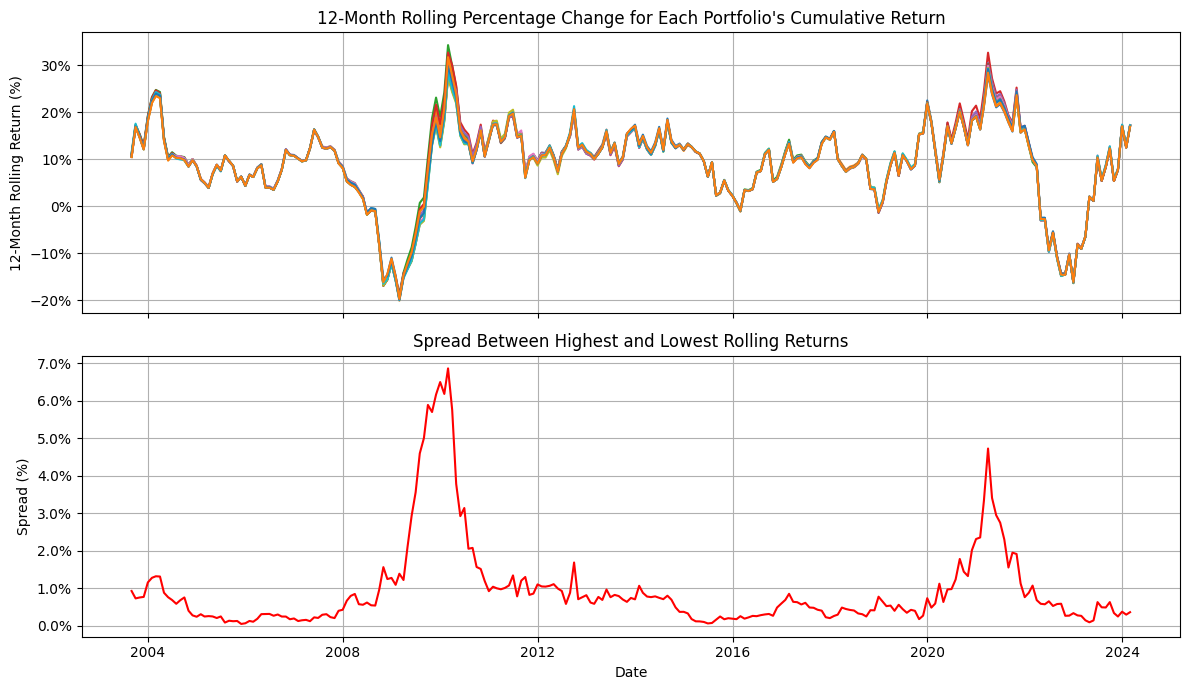

In [8]:
def plot_rolling_returns_and_spread(portfolio_returns):
    # Calculate cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()

    # Calculate the rolling 12-month percentage change
    rolling_returns = cumulative_returns.pct_change(periods=12)

    # Calculate the spread
    spread = rolling_returns.max(axis=1) - rolling_returns.min(axis=1)

    # Creating subplots
    fig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

    # Plot rolling returns
    for column in rolling_returns.columns:
        axs[0].plot(rolling_returns.index, rolling_returns[column], label=column)
    axs[0].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    axs[0].set_ylabel('12-Month Rolling Return (%)')
    axs[0].set_title('12-Month Rolling Percentage Change for Each Portfolio\'s Cumulative Return')
    axs[0].grid(True)

    # Plot spread
    axs[1].plot(spread.index, spread, color='red')
    axs[1].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    axs[1].set_ylabel('Spread (%)')
    axs[1].set_xlabel('Date')
    axs[1].set_title('Spread Between Highest and Lowest Rolling Returns')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


plot_rolling_returns_and_spread(portfolio_returns)

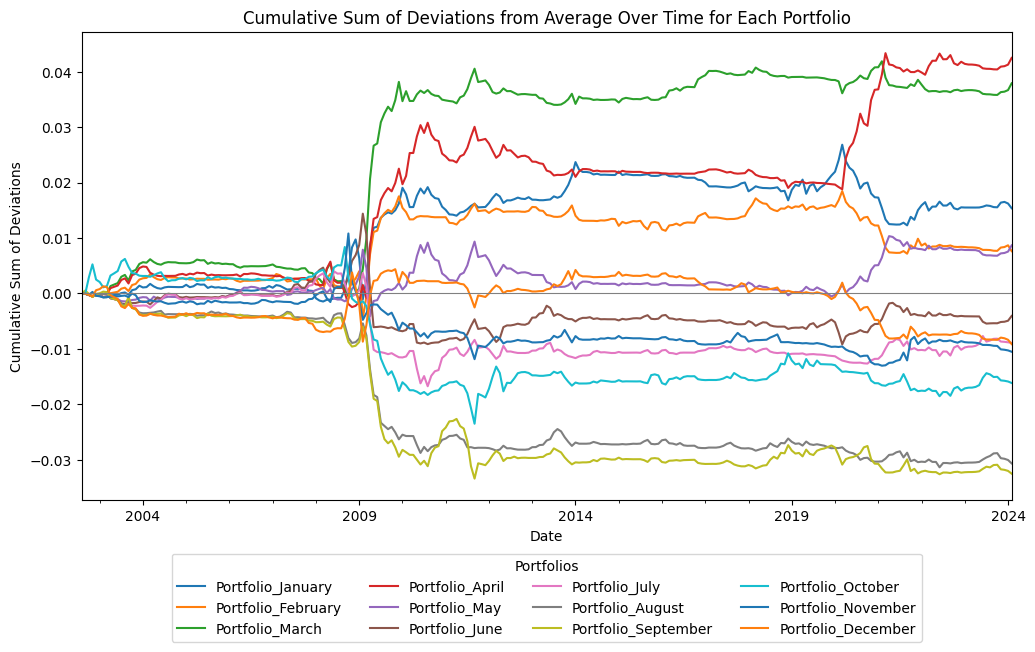

In [7]:
def calculate_luck_factor(portfolio_returns):
    # Calculate the average return for each time period (row)
    average_returns = portfolio_returns.mean(axis=1)

    # Calculate deviations from the average for each portfolio
    deviations = portfolio_returns.subtract(average_returns, axis=0)

    return deviations


luck_factors = calculate_luck_factor(portfolio_returns)

# Sum of deviations through time for each portfolio
cumulative_deviations = luck_factors.cumsum()

# Plot Result
cumulative_deviations.plot(figsize=(12, 6))
plt.title('Cumulative Sum of Deviations from Average Over Time for Each Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Sum of Deviations')
plt.axhline(0, color='grey', linewidth=0.8)
plt.legend(title='Portfolios', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=4)
plt.subplots_adjust(bottom=0.1)
plt.show()